In [1]:
import sys 
sys.path.insert(0,'./src')
import numpy as np

import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from time import time
from multiprocessing import Pool

# import dynamics_test_ as dynamics_ 
import dynamics_bkrpt as dynamics_
import dynamics_ as dynamics
import economy_bkrpt as economy
degree,n = 20,300

delta = 10**-3
u = np.random.uniform(-1,1)


In [2]:
def multi_get(input,func, processes= 5, array = True, tq = True):
    pool = Pool(processes = processes)
    try : 
        if tq : 
            output = pool.map(func,tqdm(input))
        else : 
            output = pool.map(func,input)
        pool.close()
    except KeyboardInterrupt or Exception : 
        pool.terminate()
        raise 
    finally : 
        pool.join()
    if array : return np.array(output)
    else : return output

In [3]:
np.random.seed(0)
eco_initial_conditions = {
    
    "n": n,
    "d":degree,
    "netstring":"regular",
    "directed":True,
    "j0":np.ones(n),
    "a0":np.ones(n)*0.5,
    "q":0.,
    "b":0.95,
    "nested_CES":[True,1]
    
}

house_initial_conditions = {
     "l_0":1, # Propension à travailler
     "theta":(np.ones(n)/n).copy(),
     "gamma":1,
     "phi":1,
     "omega_p":0.1,
     "f":None,
     "r":None

 }

firm_initial_conditons = {
    "z":np.ones(n), 
    "sigma":np.ones(n)*0.3,
    "alpha":0.5,
    "alpha_p":0.5,
    "beta":0.5,
    "beta_p":0.5,
    "omega":0.1
}


eps = 100
def init_d(d,house_initial_conditions,firm_initial_conditons,eps):
    np.random.seed(1)
    try :
        d.eco.clear_all()
    except : pass
    d.eco.init_house(**house_initial_conditions)
    d.eco.init_firms(**firm_initial_conditons)
    d.eco.set_quantities() # Help for equilibrium quantities. 
    d.eco.set_eps_cal(eps) # Changes z to have the samellest eigen value of M equals to eps.
    d.eco.compute_eq() 
    initial_conditions = {
    "p0":d.eco.p_eq*(1+delta*np.random.uniform(-1,1,n)),    # Prices [0.1,1]
    "w0":1,               # Wage at 1 
    "g0":d.eco.g_eq, # Prod [0.001,0.01]
    "t1":d.eco.g_eq, # Target [0.001,0.01]
    "s0":np.zeros((n,n)), # Stock 0
    "B0":0,               # Savings 0
    }
    d.set_initial_conditions(**initial_conditions)
    return d

# degree,n = 5,300
np.random.seed(0)
e = economy.Economy(**eco_initial_conditions)
d = dynamics.Dynamics(e,100)
d = init_d(d,house_initial_conditions,firm_initial_conditons,eps)
d.discrete_dynamics()

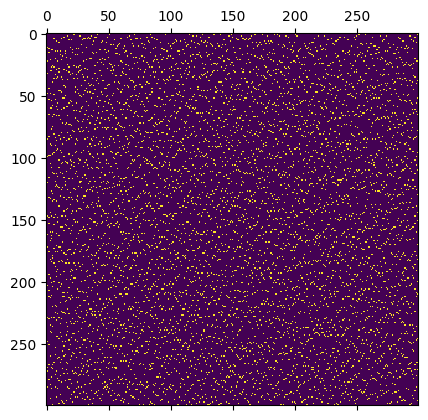

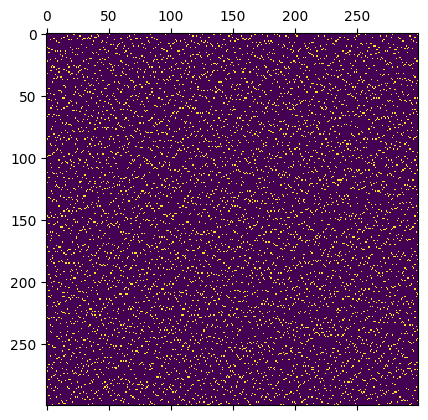

In [4]:
plt.matshow(d.eco.j-d.eco.leontief_net)
plt.matshow(d.eco.j)

In [5]:
def display_results(d,min_loss,axs = None ):
    
#     try : del e,d_
#     except : print("No delete")
#     e = Economy(**eco_initial_conditions)
    d_ = dynamics_.Dynamics(e,100)
    d_ = init_d(d_,house_initial_conditions,firm_initial_conditons,eps)
    d_.update_min_loss(min_loss)
    try :
        d_.discrete_dynamics()
    except Exception as ex : 
        print(ex)
        return d_
    arg_n_max = np.argmax(d_.n_bkrpt)
    d_.n_bkrpt[arg_n_max:] = d_.n_bkrpt[arg_n_max]
    
    if axs is None : 
        fig,axs = plt.subplots(nrows = 1, ncols = 4, figsize=(10,5),dpi = 150, sharex = False)
        
    axs[0].plot(d.prices[1:].mean(axis = -1),label = "Theo")
    axs[0].plot(d_.prices[1:].mean(axis = -1),label = "Swann")
    axs[0].set_ylabel(r"$\bar{p}$")
    axs[0].set_title(f"Max loss {min_loss}")
    axs[0].set_xlabel(r"$t$")

    axs[1].plot(d.prods[1:].mean(axis = -1),label = "Theo")
    axs[1].plot(d_.prods[1:].mean(axis = -1),label = "Swann")
    axs[1].set_title(fr"$eps$ = {round(d_.eco.get_eps_cal(),3)}")
    axs[1].set_ylabel(r"$\bar{y}$")
    axs[1].set_xlabel(r"$t$")
    
    axs[2].matshow(d_.eco.j)
    axs[2].set_title("Production network")
    
    axs[3].matshow(1-d_.contagion_matrix)
    axs[3].set_title("Contagion matrix")

    ax2 = axs[0].twinx()
    ax2.plot(d_.n_bkrpt,color = "black", alpha = 0.5,linestyle = "dashed",label = "Theo")
    ax2 = axs[1].twinx()
    ax2.plot(d_.n_bkrpt,color = "black", alpha = 0.5,linestyle = "dashed",label = "Swann")
    ax2.set_ylabel("n_bkrpt")
    
    axs[0].legend(loc = "upper left")
    axs[1].legend(loc = "upper left")
    if axs is None : 
        plt.tight_layout()
#     print(f"Min loss = {min_loss}, eps = {round(d_.eco.get_eps_cal(),3)} ")
    return d_

5it [00:16,  3.33s/it]


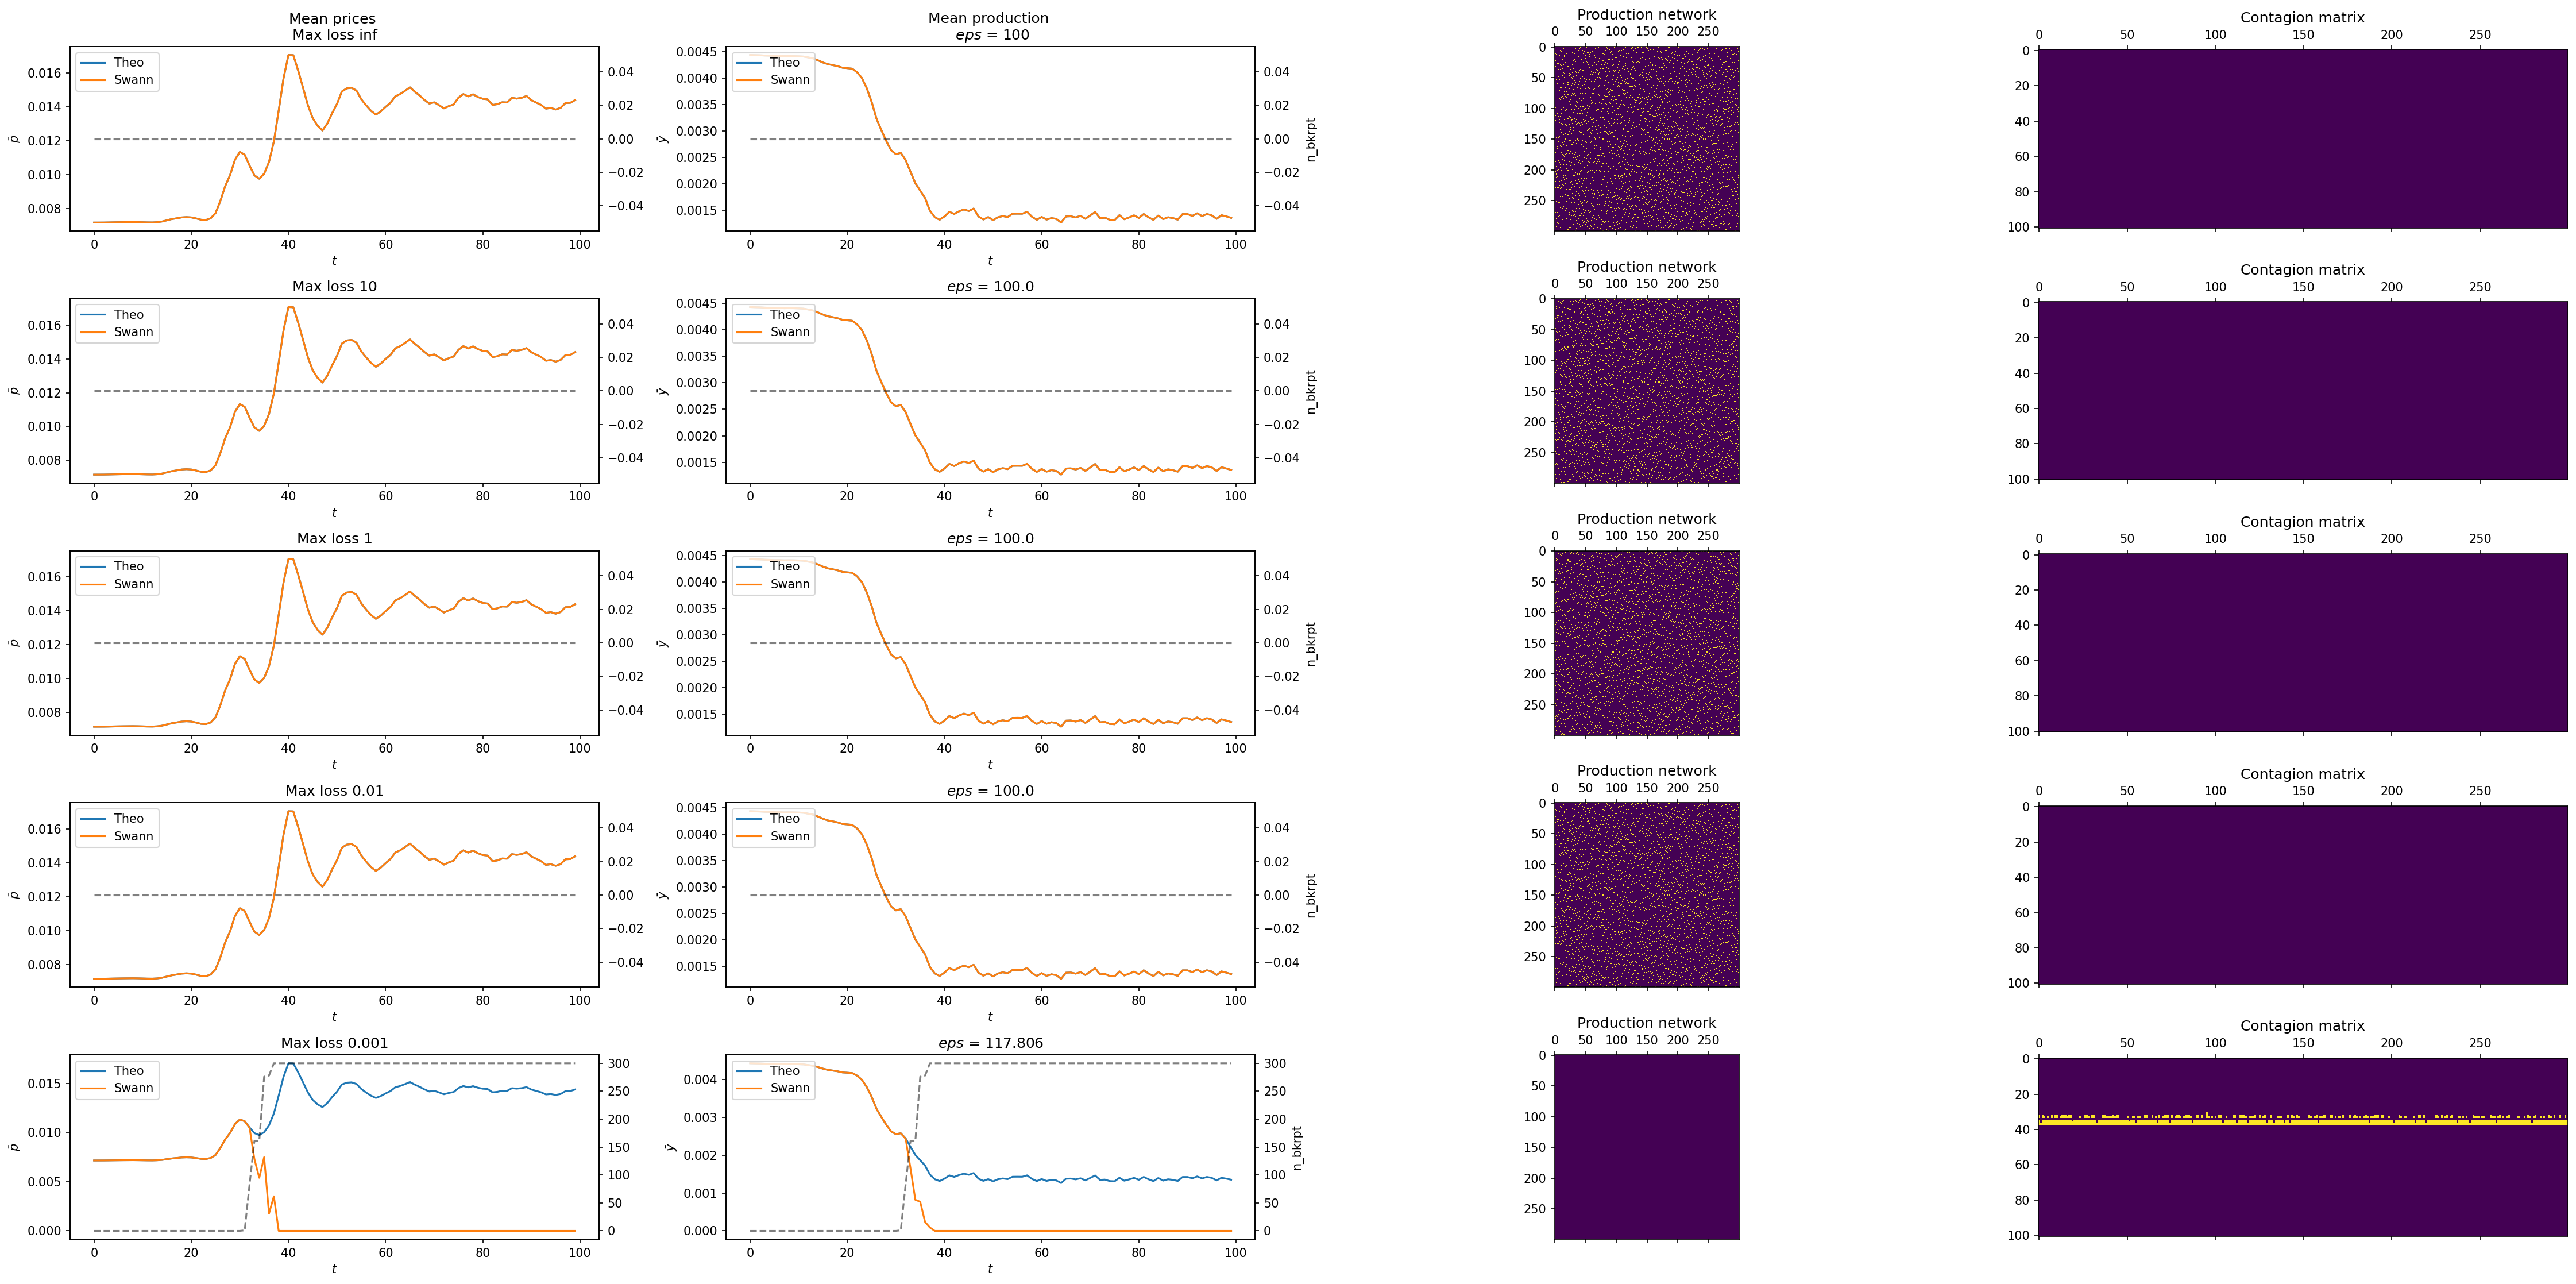

In [6]:
fig, axs = plt.subplots(nrows = 5, ncols = 4, figsize=(30,15),dpi = 150, sharex = False)    
for i,min_loss in tqdm(enumerate([np.inf,10,1,0.01,0.001])):
    d_ = display_results(d,min_loss,axs[i,:])
axs[0,0].set_title(f"Mean prices \n Max loss inf ")
axs[0,1].set_title(f"Mean production \n $eps$ = {round(100,3)}")
axs[0,2].set_title("Production network")
axs[0,3].set_title("Contagion matrix")
plt.tight_layout()
fig.savefig("bkrpt.pdf")

5it [00:17,  3.45s/it]


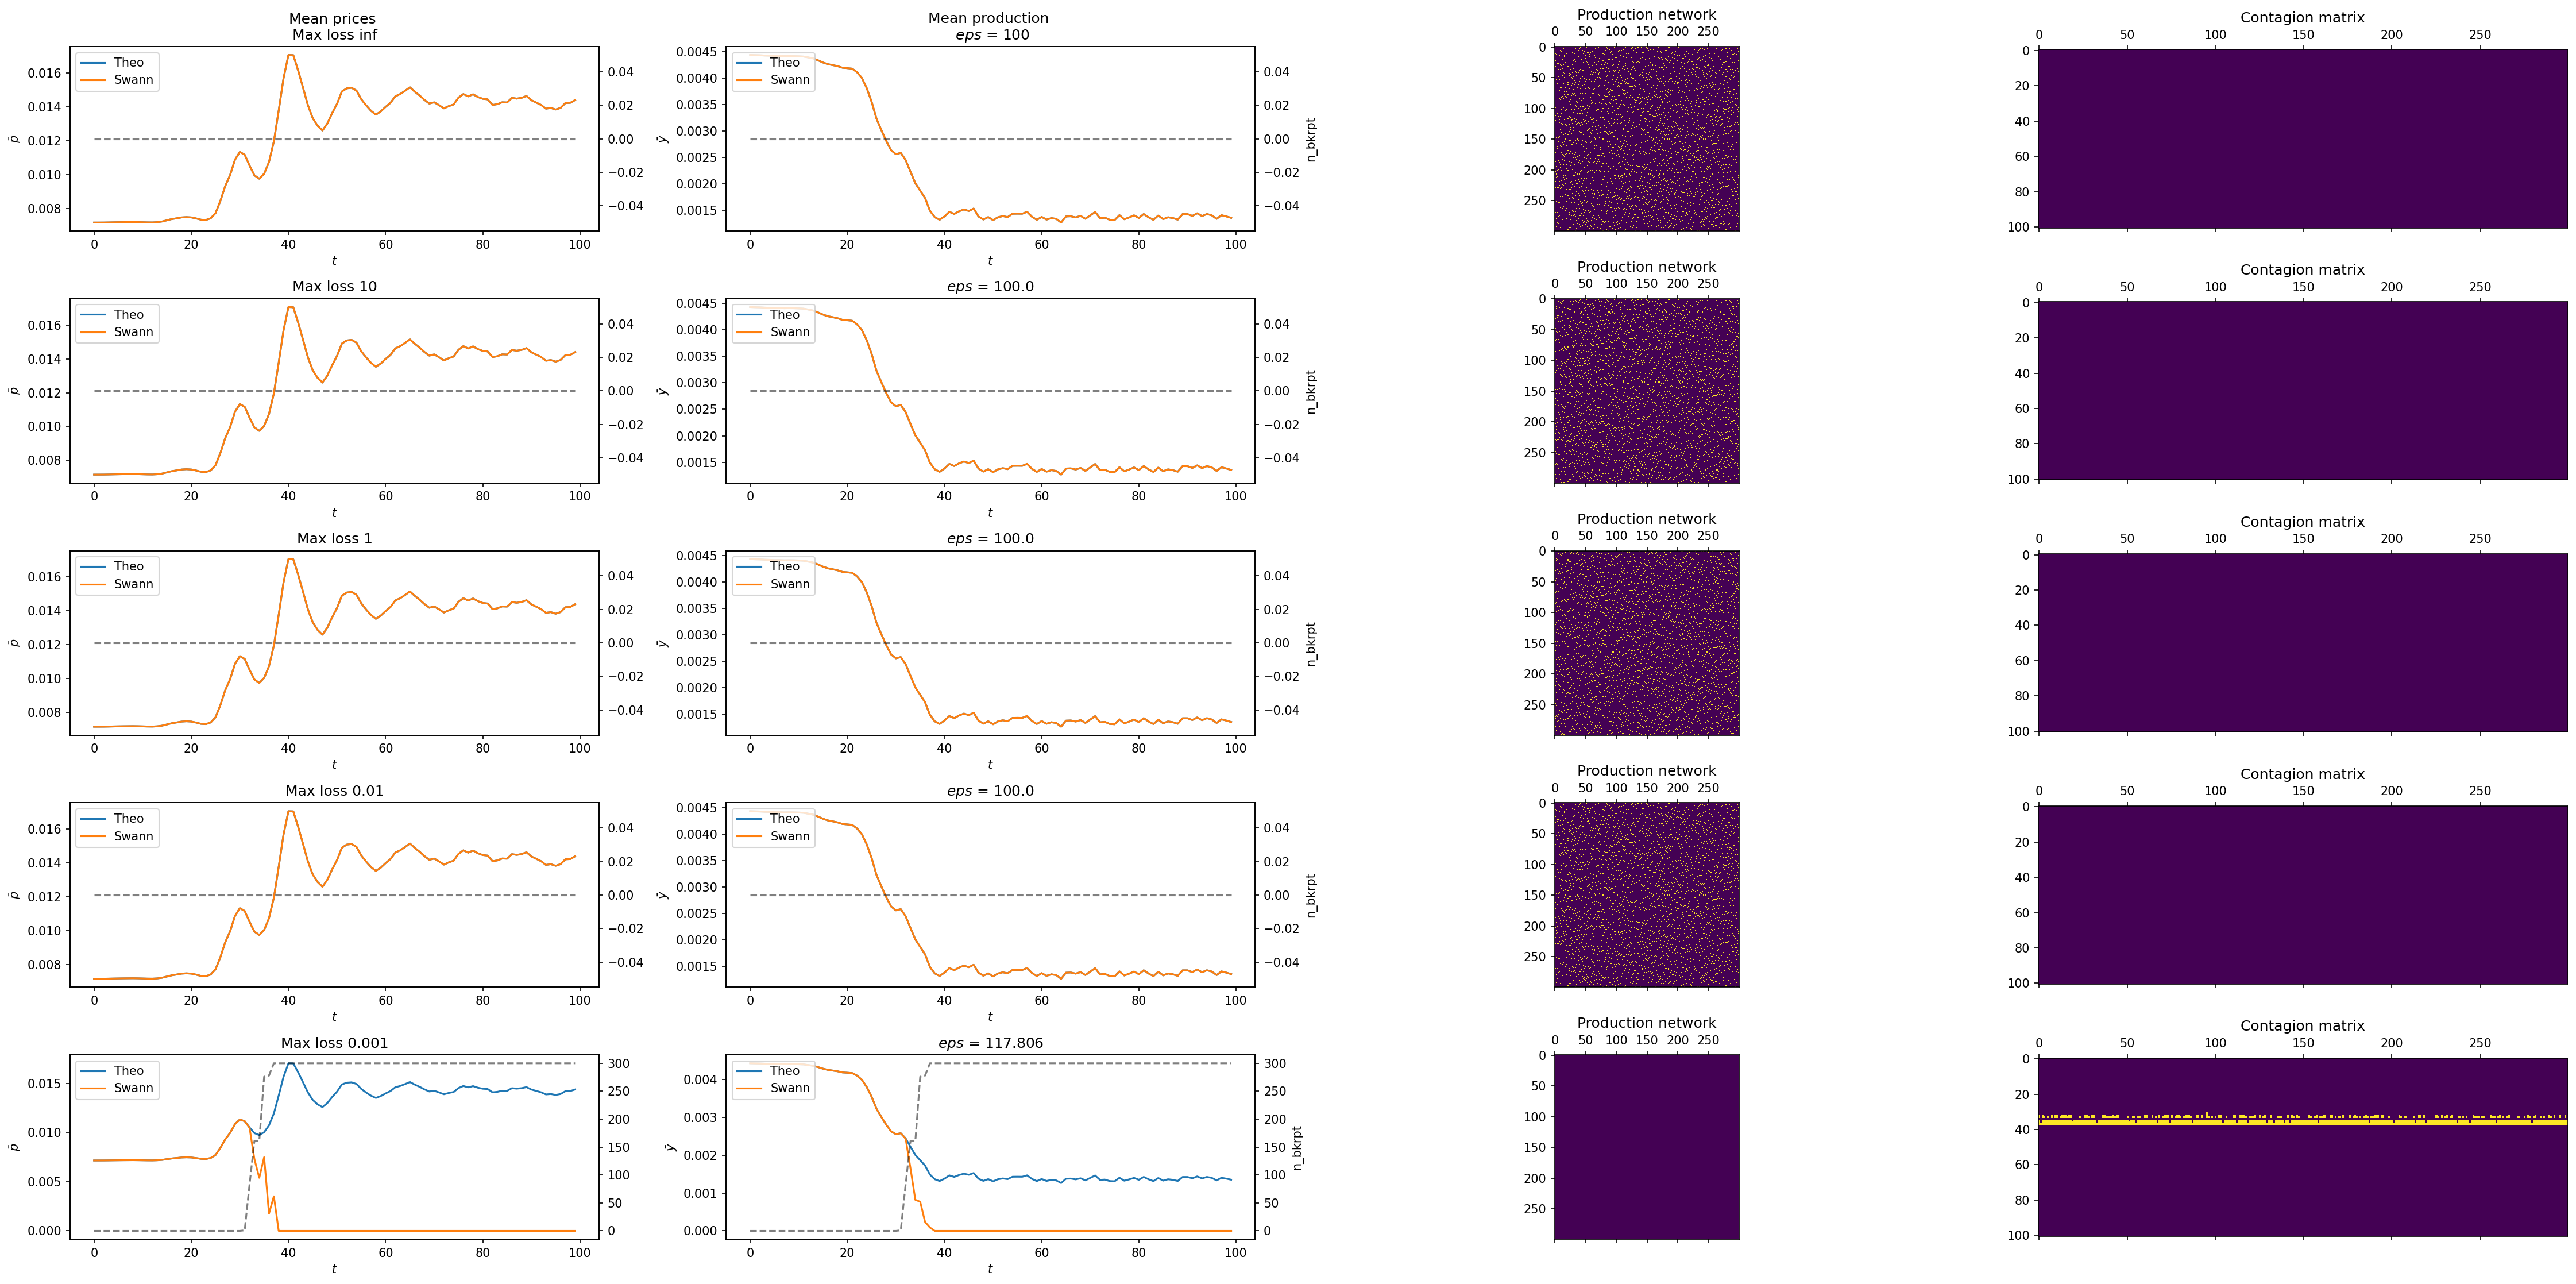

In [7]:
fig, axs = plt.subplots(nrows = 5, ncols = 4, figsize=(30,15),dpi = 150, sharex = False)    
for i,min_loss in tqdm(enumerate([np.inf,10,1,0.01,0.001])):
    d_ = display_results(d,min_loss,axs[i,:])
axs[0,0].set_title(f"Mean prices \n Max loss inf ")
axs[0,1].set_title(f"Mean production \n $eps$ = {round(100,3)}")
axs[0,2].set_title("Production network")
axs[0,3].set_title("Contagion matrix")
plt.tight_layout()
fig.savefig("bkrpt.pdf")

In [8]:
temp_ = np.where(d_.eco.a_a.sum(axis = 1)==0.5)
# assert temp_ == set([0,1]), f"Sum of a_a contains :{temp_-set([0,1])} {set(srv_idx)}" 
# assert np.isnan(d.eco.a_a).sum() == 0 , "NaN in a_a"
temp_

(array([], dtype=int64),)

In [9]:
labour_only = np.where(d_.eco.a_a[d_.srv_idx,:][:,1:].sum(axis = 1) == 0)
d_.eco.a_a[labour_only,0] = 1. 

In [10]:
d_.eco.a_a[d_.srv_idx,:][:,1:].sum(axis = 1) == 0

array([], dtype=bool)